In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
import testcases
from importlib import reload


### Auxiliary Functions

In [3]:
def myLog(x):
    logx = np.log(np.maximum(1e-20,x))
    # logx = np.log(x)
    if np.isnan(logx).any() == True:
        print(f'Inside myLog: NaN encountered!\nmin_x:{x.min()}')
        return None
    else:
        return logx

def x2Y(x):
    Y = x[0:2*M].reshape(-1,2)
    return Y

def x2P(x):
    P = x[2*M:].reshape(-1,M)
    return P

def YP2x(Y, P):
    y = Y.flatten()
    p = P.flatten()
    x = np.concatenate((y,p))
    return x

### FLP Class

In [6]:
# create FLP class and its associated functions
class FLP():
    # declare the class variables
    N : int # number of resources
    M : int # number of facilities
    d : int # dimension of the problem
    resLoc : np.ndarray # resource locations
    rho : np.ndarray # rosource weights
    C : np.ndarray # capacity constraints
    
    # initialize the class variables
    def __init__(self, N, M, d, resLoc, rho, C, P_eps, beta_tol):
        self.N = N
        self.M = M
        self.d = d
        self.resLoc = resLoc
        self.rho = rho
        self.C = C
        self.P_eps = P_eps
        self.beta_tol = beta_tol
        print('================= Class FLP() initialized =================')

    # function to plot FLP results
    def plot_flp(self, res_means, facLoc0):
        ''' 
        input - flp : the class instance
                N : # resources
                M : # facilities
                resLoc : resource locations
                facLoc0 : initial facility locations
                facLoc_opt : final facility locations (supposedly optimal)
                ineq_figures : data for plotting inequality constraints, datatype is variable
        output: None
        '''
        N = self.N
        M = self.M
        resLoc = self.resLoc
        # initialize figure
        figure, axes = plt.subplots()
        # resources locations
        plt.scatter(resLoc[:, 0], resLoc[:, 1], marker = "o", color = 'blue', alpha=0.3)
        # resource means
        plt.scatter(res_means[:, 0], res_means[:, 1], marker = ".", color = 'red')
        # initial facility locations
        plt.scatter(facLoc0[:, 0], facLoc0[:, 1], marker = "D", color = 'green')
        # final facility locations
        # plt.scatter(facLoc_opt[:, 0], facLoc_opt[:, 1], marker = "+", color = 'black')
        plt.title('Facility and resource locations - N = ' + str(N) + ', M = ' + str(M))
        # plt.legend(['resources', 'cluster means', 'initial facilities', 'optimal facilities'])

        plt.grid()
        plt.show()
        return None

    # function to evaluate free energy
    def free_energy(self, x, beta):
        resLoc = self.resLoc
        Y = x2Y(x)
        P = x2P(x)
        X_Y = np.array([self.resLoc-y for y in Y])
        D = np.sum(X_Y**2,axis=2).T
        if beta <= self.beta_tol:
            F = np.sum(self.rho*np.sum(P*(beta * D + myLog(P)),axis=1,keepdims=True)) + np.log(flp.M)
        else:
            F = np.sum(self.rho*np.sum(P*(D + 1/beta * myLog(P)),axis=1,keepdims=True)) + 1/beta * np.log(flp.M)
        return F

    # function to evaluate gradient of free energy
    def gradF(self, x, beta):
        Y = x2Y(x)
        P = x2P(x)
        P1 = np.expand_dims(P.T,axis=2)
        X_Y = -np.array([self.resLoc-y for y in Y])
        D = np.sum(X_Y**2,axis=2).T
        if beta <= self.beta_tol:
            dF_Y = 2*beta*np.sum(self.rho * P1 * X_Y, axis=1)
            dF_P = self.rho*(beta*D + (myLog(P) + 1))
        else:
            dF_Y = 2*np.sum(self.rho * P1 * X_Y, axis=1)
            dF_P = self.rho*(D + 1/beta * (myLog(P) + 1))    

        dFdx = np.concatenate((dF_Y.flatten(),dF_P.flatten()))
        
        return dFdx

    # function to evaluate inequality constraints
    def G_ineq(self, x):
        P = x2P(x)
        H1 = ((P-self.P_eps)*(P-1)).flatten()
        H2 = np.sum(self.rho*P,axis=0) - self.C
        # print(H2)
        G = np.concatenate((H1,H2))
        return G

    # function to evaluate equality constraints
    def H_eq(self, x):
        P = x2P(x)
        H = np.sum(P,axis=1)-1
        return H

    # function to evaluate gradient of inequality constraints
    def gradG(self, x):
        N = self.N
        M = self.M
        P = x2P(x)
        dG11 = np.zeros((N*M,2*M))
        dG12 = np.diag(2*P.flatten()-1-self.P_eps)
        dG21 = np.zeros((M,2*M))
        dG22 = np.kron((self.rho).T, np.eye(M))
        # print(f'shapes: dG11 {dG11.shape}, dG12 {dG12.shape}, dG21 {dG21.shape}, dG22 {dG22.shape}')
        dG = np.block([[dG11, dG12],[dG21, dG22]])
        return dG

    # function to evaluate gradient of equality constraints
    def gradH(self, x):
        N = self.N
        M = self.M
        H1 = np.zeros((N,2*M))
        H2 = block_diag(*([np.ones((1,M))]*N))
        # print(f'shapes H1 {H1.shape} H2 {H2.shape}')
        dH = np.concatenate((H1,H2),axis=1)
        return dH

    # function to optimize free energy at given beta using trust-constr method
    def optimize_trust_constr(self, x0, beta):
        inequality_constraint = NonlinearConstraint(self.G_ineq, -np.inf, 0.0, jac=self.gradG)
        equality_constraint = NonlinearConstraint(self.H_eq, 0.0, 0.0, jac=self.gradH)
        res = minimize(
            self.free_energy, x0,
            jac = self.gradF,
            args=(beta,), 
            method='trust-constr', 
            constraints=[inequality_constraint, equality_constraint],
            options={'verbose':2})
        return res.x, res.fun

    # function to optimize free energy at given beta using SLSQP method
    def optimize_SLSQP(self, x0, beta, ftol):
        inequality_constraint = {'type':'ineq', 'fun': lambda x: -self.G_ineq(x), 'jac': lambda x: -self.gradG(x)}
        equality_constraint = {'type':'eq', 'fun':self.H_eq, 'jac':self.gradH}
        res = minimize(
            self.free_energy, x0,
            jac = self.gradF,
            args=(beta,), 
            method='SLSQP',
            constraints=[inequality_constraint, equality_constraint],
            options={'disp':True, 'ftol':ftol})
        return res.x, res.fun

    # function to perform deterministic annealing
    def anneal(self, x0, beta0, betaf, beta_grow, SLSQP_ftol):
        xb = x0
        beta = beta0
        F_array = []
        b_array = []
        P_array = np.array([x2P(x0)])
        Y_array = np.array([x2Y(x0)])

        while beta <= betaf:
        
            xb, Fb = self.optimize_SLSQP(xb, beta, SLSQP_ftol)
            xb[:2*self.M] += np.random.multivariate_normal(np.zeros(2*self.M), 0.001*np.eye(2*self.M))
            beta *= beta_grow
        
            # store data
            F_array.append(Fb)
            b_array.append(beta)
            P_array = np.concatenate((P_array, np.array([x2P(xb)])), axis=0)
            Y_array = np.concatenate((Y_array, np.array([x2Y(xb)])), axis=0)

            # print
            print(f'beta:{beta:.3e}\tF:{Fb:.3e}')

        return F_array, b_array, P_array, Y_array


### Initialize an FLP problem, and test all the functions

================= Class FLP() initialized =================


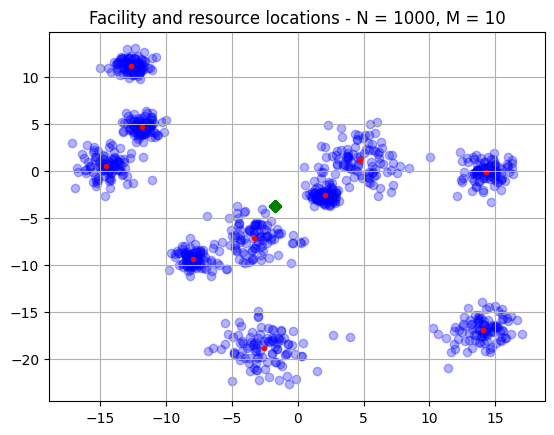

rho shape: (1000, 1)
cluster split: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
capacity limit: [0.10001 0.10001 0.10001 0.10001 0.10001 0.10001 0.10001 0.10001 0.10001
 0.10001]

centroid:[-1.76907538 -3.74851823]


In [7]:
reload(testcases)
# load a testcase
N, M, d, resLoc, Y0, res_means, split_pct, rho = testcases.testcases('large_tc_1000_10')
# C = np.random.uniform(0,1,len(split_pct))
C = np.ones(shape=split_pct.shape)
C = C/np.sum(C) + 1e-5

# initialize FLP class
flp = FLP(N, M, d, resLoc, rho, C, P_eps=1e-8, beta_tol=1e-10)
flp.plot_flp(res_means, Y0)
print(f'rho shape: {rho.shape}')
print(f'cluster split: {split_pct}')
print(f'capacity limit: {C}\n')
centroid = np.sum(rho*resLoc, axis=0)
print(f'centroid:{centroid}')

In [8]:
# initial state
# P0 = np.ones(shape=(flp.N, flp.M))
P0 = np.random.uniform(0,1,(flp.N, flp.M)) + flp.P_eps
P0 = P0/P0.sum(axis=1,keepdims=True)
x0 = YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

# test functions
beta0 = 1e-3; print(f'beta\tvalue:{beta0:.2e}')
F0 = flp.free_energy(x0, beta0); print(f'F0\tvalue:{F0:.2f}')
dFdx0 = flp.gradF(x0, beta0); print(f'dFdx\tshape:{dFdx0.shape}\tmax norm:{np.max(np.abs(dFdx0)):.3f}')
G0 = flp.G_ineq(x0); print(f'G0\tshape:{G0.shape}\tmax:{np.max(G0):.3f}\tcapacity:{G0[flp.N*flp.M:]}')
dGdx0 = flp.gradG(x0); print(f'dGdx\tshape:{dGdx0.shape}\tmax norm:{np.max(np.abs(dGdx0)):.3f}')
H0 = flp.H_eq(x0); print(f'H0\tshape:{H0.shape}\tmax:{np.max(np.abs(H0)):.3e}')
dHdx0 = flp.gradH(x0); print(f'dHdx0\tshape:{dHdx0.shape}\tmax norm:{np.max(np.abs(dHdx0)):.3f}')



x0	shape:(10020,)
beta	value:1.00e-03
F0	value:372.21
dFdx	shape:(10020,)	max norm:9.755
G0	shape:(10010,)	max:0.005	capacity:[ 0.00252668 -0.00048568 -0.00366495 -0.0012004   0.00500598  0.00273824
  0.00060584 -0.00023163 -0.00528212 -0.00011194]
dGdx	shape:(10010, 10020)	max norm:1.000
H0	shape:(1000,)	max:4.441e-16
dHdx0	shape:(1000, 10020)	max norm:1.000


In [9]:
# test optimizer
x1, F1 = flp.optimize_SLSQP(x0, beta0, ftol=1)

In [21]:
F1

19.855441136842174

In [15]:
Y1 = x2Y(x1)
P1 = x2P(x1)
print(f'Y:{Y1}')
print(f'P:{P1}')

Y:[[ 9.32497586 10.0218682 ]
 [-9.80094145  0.95709852]
 [-4.895259   14.78211534]]
P:[[ 1.00000186e-08  1.00000002e+00 -2.53832294e-08]
 [ 1.00000143e-08  9.99999980e-01  9.99999059e-09]
 [ 1.00000049e-08  9.99999980e-01  1.00000138e-08]
 [ 1.00000042e-08  9.99999982e-01  8.42195673e-09]
 [ 1.00000105e-08  9.99999981e-01  8.86969263e-09]
 [ 1.00000029e-08  9.99999980e-01  1.00000102e-08]
 [ 1.00000174e-08  9.99994110e-01  5.87996379e-06]
 [ 9.99999367e-09  9.99999980e-01  1.00000119e-08]
 [ 1.00000137e-08  9.99999980e-01  9.99999969e-09]
 [ 1.00000189e-08  9.99999980e-01  9.99999640e-09]
 [ 1.00000259e-08  9.99999985e-01  4.69630840e-09]
 [ 1.00000082e-08  9.99999980e-01  9.87174941e-09]
 [ 1.00000014e-08  9.99998120e-01  1.87018224e-06]
 [ 1.00000551e-08  9.99999980e-01  9.99200954e-09]
 [ 1.00000509e-08  9.99999980e-01  9.96783867e-09]
 [ 1.00000040e-08  9.99999980e-01  1.00000117e-08]
 [ 1.00000099e-08  9.99999980e-01  1.00000027e-08]
 [ 1.00000359e-08  9.99999980e-01  9.99998723e-

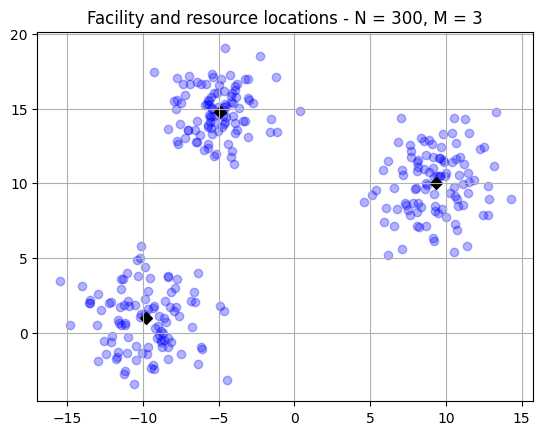

In [16]:
flp.plot_flp(res_means, Y1)

In [50]:
F_array, b_array, P_array, Y_array = flp.anneal(x0, beta0=1e-3, betaf=1e2, beta_grow=2)

beta:2.000e-03	F:1.068e+02
beta:4.000e-03	F:1.068e+02
beta:8.000e-03	F:1.068e+02
beta:1.600e-02	F:1.040e+02
beta:3.200e-02	F:7.274e+01
beta:6.400e-02	F:4.234e+01
beta:1.280e-01	F:2.572e+01
beta:2.560e-01	F:1.732e+01
beta:5.120e-01	F:1.307e+01
beta:1.024e+00	F:1.095e+01
beta:2.048e+00	F:9.884e+00
beta:4.096e+00	F:9.345e+00
beta:8.192e+00	F:9.078e+00
beta:1.638e+01	F:8.944e+00
beta:3.277e+01	F:8.877e+00
beta:6.554e+01	F:8.844e+00
beta:1.311e+02	F:8.827e+00


In [51]:
Y_array[-1]

array([[-10.0502093 ,   0.93535552],
       [ -4.74282267,  14.94605052],
       [  9.06404896,   9.98710065]])

In [52]:
P_array[-1]

array([[9.99999980e-01, 9.99999349e-09, 1.00000766e-08],
       [9.99999980e-01, 9.99997864e-09, 1.00001040e-08],
       [9.99999980e-01, 1.00000161e-08, 1.00000621e-08],
       [9.99999980e-01, 9.99999623e-09, 1.00001295e-08],
       [9.99999980e-01, 9.99999068e-09, 1.00000897e-08],
       [9.99999980e-01, 9.99999646e-09, 1.00001124e-08],
       [9.99999980e-01, 9.99999092e-09, 1.00000727e-08],
       [9.99999980e-01, 9.99998592e-09, 1.00000786e-08],
       [9.99999980e-01, 1.00000288e-08, 1.00001062e-08],
       [9.99999980e-01, 1.00000235e-08, 1.00000643e-08],
       [9.99999980e-01, 1.00000039e-08, 1.00000936e-08],
       [9.99999980e-01, 1.00000217e-08, 1.00001189e-08],
       [9.99999980e-01, 1.00000230e-08, 1.00000711e-08],
       [9.99999980e-01, 9.99999511e-09, 1.00000936e-08],
       [9.99999980e-01, 1.00000221e-08, 1.00000737e-08],
       [9.99999980e-01, 9.99999910e-09, 1.00000948e-08],
       [9.99999980e-01, 1.00000180e-08, 1.00000801e-08],
       [9.99999980e-01, 9.99999

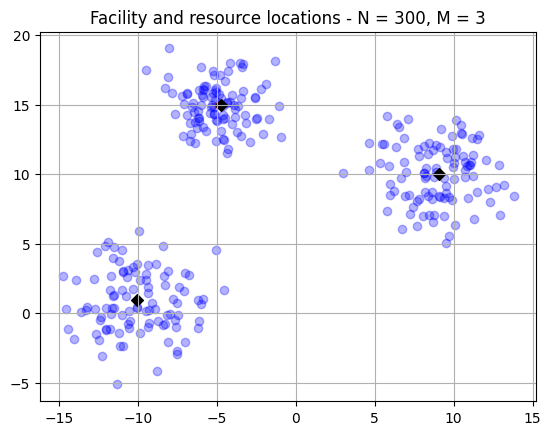

In [53]:
flp.plot_flp(res_means, Y_array[-1])

In [123]:
# test optimizer
# x2, F2 = flp.optimize_trust_constr(x0, beta0)


In [124]:
# Y2 = x2Y(x2)
# P2 = x2P(x2)
# print(f'Y:{Y2}')
# print(f'P:{P2}')